## Imports

In [1]:
# !pip install opendatasets

In [2]:
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Get and load the data

In [3]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data",
                          data_dir='.')

Skipping, found downloaded files in "./daily-climate-time-series-data" (use force=True to force download)


In [4]:
weather_data = pd.read_csv("./daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
weather_data.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


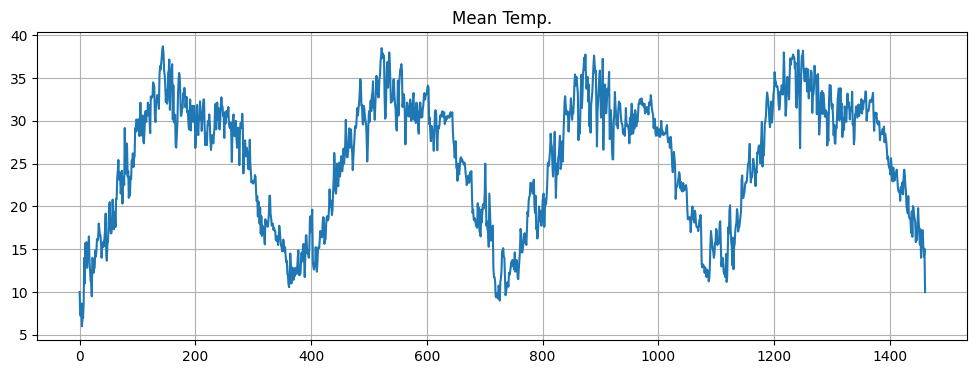

In [6]:
# Plotting mean temps
weather_data['meantemp'].plot(figsize=(12, 4))
plt.grid(True)
plt.title("Mean Temp.")
plt.show()

In [7]:
weather_data.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


In [8]:
# Get the mean temps column data
mean_temps = weather_data['meantemp']
mean_temps.shape

(1462,)

## Splitting data into training and validation sets

In [9]:
# Splitting into train and validation data
training_size = int(len(mean_temps) * 0.80)

train_data = mean_temps[:training_size].to_numpy()
valid_data = mean_temps[training_size:].to_numpy()

train_data.shape, valid_data.shape

((1169,), (293,))

In [10]:
train_data

array([10.        ,  7.4       ,  7.16666667, ..., 24.5625    ,
       24.25      , 22.375     ])

In [11]:
# scaling the values - Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
valid_data = scaler.fit_transform(valid_data.reshape(-1, 1))

In [12]:
train_data.shape, valid_data.shape

((1169, 1), (293, 1))

In [13]:
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []

    for i in range(len(dataset) - time_steps):
        a = dataset[i:time_steps + i]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])

    return np.array(dataX), np.array(dataY)

In [14]:
TIME_STEPS_DATA = 100  # cannot exceed test data instances

X_train, y_train = create_dataset(train_data, time_steps=TIME_STEPS_DATA)
X_valid, y_valid = create_dataset(valid_data, time_steps=TIME_STEPS_DATA)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1069, 100, 1), (1069, 1), (193, 100, 1), (193, 1))

## Creating a forecasting model with 2 RNN layers

In [15]:
from tensorflow import keras

# clears the information about the created models (cache clearing)
keras.backend.clear_session()

# RNN model with single Dense layer
model = keras.models.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(TIME_STEPS_DATA, 1), return_sequences=True),
    keras.layers.LSTM(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 52545 (205.25 KB)
Trainable params: 52545 (205.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training and Validation

In [16]:
import tensorflow as tf

EPOCHS = 15


history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    batch_size=32
  )

Epoch 1/15
34/34 [==============================] - 26s 478ms/step - loss: 0.1069 - val_loss: 0.0152
Epoch 2/15
34/34 [==============================] - 9s 276ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 3/15
34/34 [==============================] - 8s 242ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 4/15
34/34 [==============================] - 9s 259ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 5/15
34/34 [==============================] - 10s 287ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/15
34/34 [==============================] - 8s 250ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 7/15
34/34 [==============================] - 9s 252ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 8/15
34/34 [==============================] - 10s 282ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/15
34/34 [==============================] - 9s 263ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/15
34/34 [==============================] - 8s 234ms/step - loss: 0.0049 - val_loss: 0.0

In [17]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

train_predict.shape, valid_predict.shape

7/7 [==============================] - 0s 31ms/step


((1069, 1), (193, 1))

## Plotting

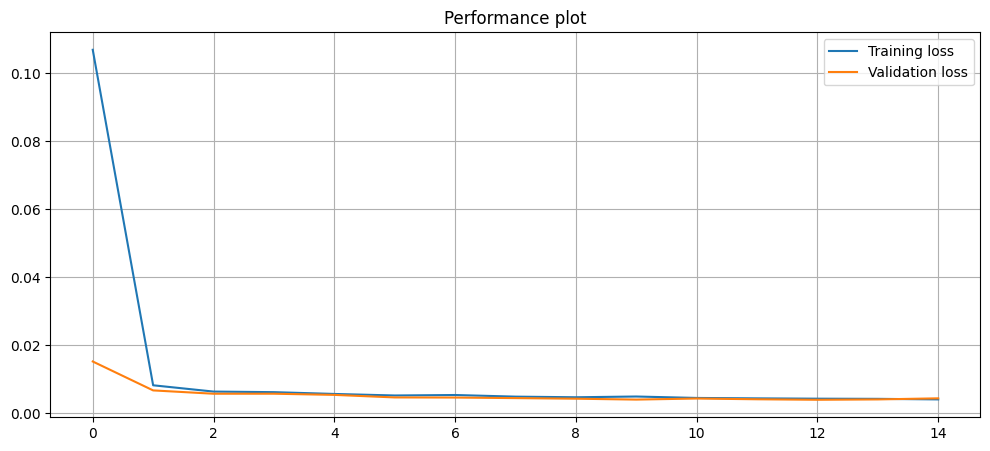

In [18]:
# plotting the performance
epochs = range(EPOCHS)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.title("Performance plot")
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.grid(True)
plt.legend()
plt.show()

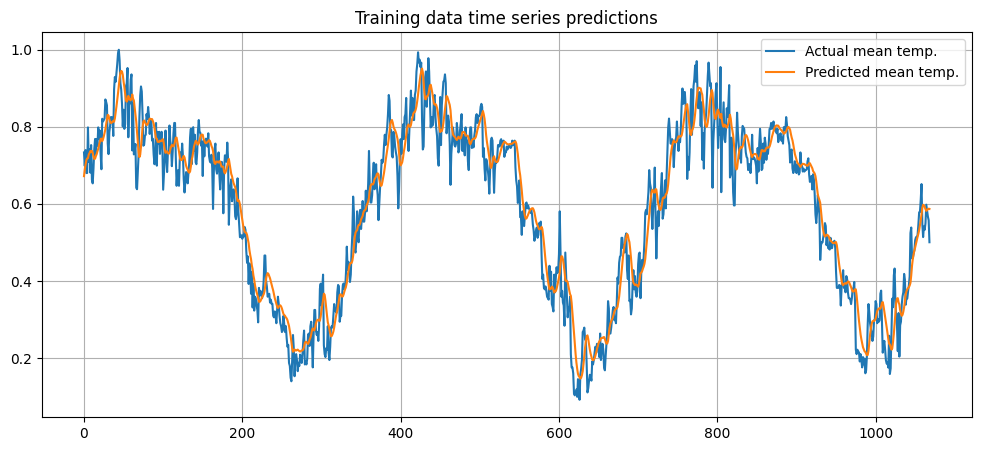

In [19]:
plt.figure(figsize=(12, 5))
plt.title("Training data time series predictions")
plt.plot(y_train, label="Actual mean temp.")
plt.plot(train_predict, label="Predicted mean temp.")
plt.grid(True)
plt.legend()
plt.show()

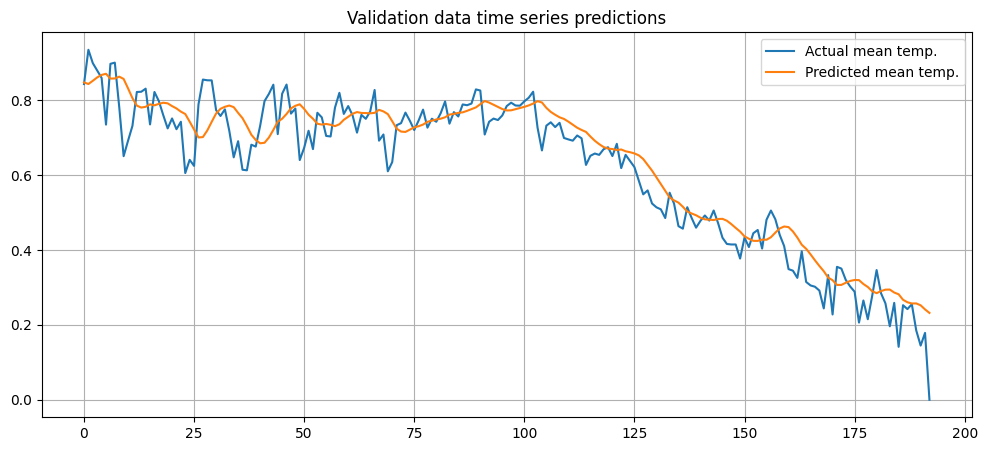

In [20]:
plt.figure(figsize=(12, 5))
plt.title("Validation data time series predictions")
plt.plot(y_valid, label="Actual mean temp.")
plt.plot(valid_predict, label="Predicted mean temp.")
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Training:\n")
print("MAE:", mean_absolute_error(y_train, train_predict))
print("MSE:", mean_squared_error(y_train, train_predict, squared=False))

print("\nValidation:\n")
print("MAE:", mean_absolute_error(y_valid, valid_predict))
print("MSE:", mean_squared_error(y_valid, valid_predict, squared=False))

Training:

MAE: 0.049629988000134385
MSE: 0.06328162550835012

Validation:

MAE: 0.05066852566577638
MSE: 0.06590665363706812


## Predictions for upcoming days

In [22]:
def predict_data(model, dataset, time_steps, days_prediction):
    preds = []
    x_input = dataset[-1]  # get the input upto given time_steps
#     print("Input Shape:", x_input.shape)

    i = 0
    while i < days_prediction:
        y_output = model.predict(x_input.reshape(1, TIME_STEPS_DATA, 1)).tolist()
        preds.append(y_output[0][0])
#         print(f"Day {i + 1} -->", preds[i])

        x_input = x_input[1:].tolist()  # shifting the input fwd
        x_input.append([preds[-1]])
        x_input = np.array(x_input)
        i += 1
#         print()

    return np.array(preds).reshape(days_prediction, 1)

In [23]:
upcoming_days = 30
y_preds = predict_data(model, X_valid, TIME_STEPS_DATA, upcoming_days)

1/1 [==============================] - 0s 44ms/step


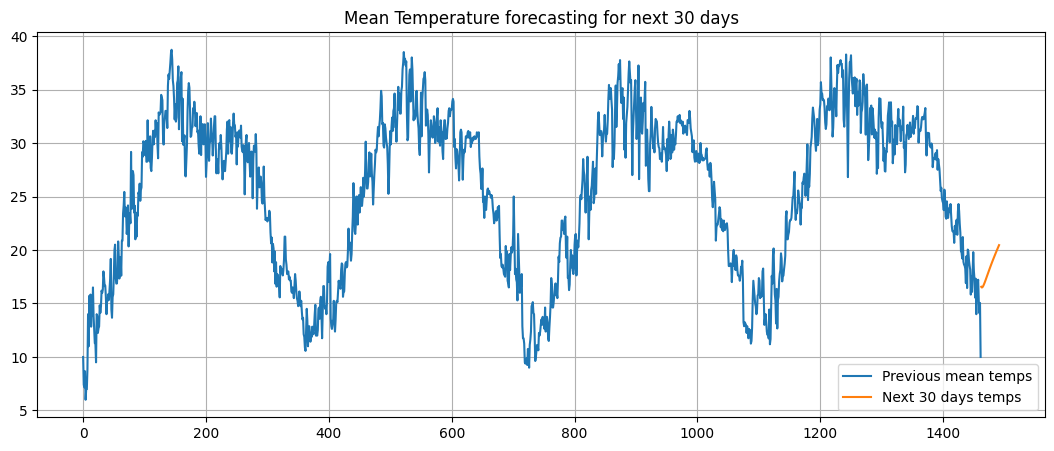

In [24]:
# Plot the data
mean_temps_length = len(mean_temps)

plt.figure(figsize=(13, 5))
plt.title(f"Mean Temperature forecasting for next {upcoming_days} days")
plt.plot(range(mean_temps_length), mean_temps, label="Previous mean temps")
plt.plot(range(mean_temps_length, mean_temps_length + upcoming_days),
         scaler.inverse_transform(y_preds), label=f"Next {upcoming_days} days temps")
plt.grid(True)
plt.legend()
plt.show()

## Testing

In [25]:
weather_test_data = pd.read_csv("./daily-climate-time-series-data/DailyDelhiClimateTest.csv")
weather_test_data.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
5,2017-01-06,19.318182,79.318182,8.681818,1011.772727
6,2017-01-07,14.708333,95.833333,10.041667,1011.375000
7,2017-01-08,15.684211,83.526316,1.950000,1015.550000
8,2017-01-09,14.571429,80.809524,6.542857,1015.952381
9,2017-01-10,12.111111,71.944444,9.361111,1016.888889


In [26]:
weather_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [27]:
# prepare test data
test_data = weather_test_data['meantemp'].to_numpy()
test_data = scaler.transform(test_data.reshape(-1, 1))

In [28]:
# split into X_test and y_test
X_test, y_test = create_dataset(test_data, time_steps=TIME_STEPS_DATA)
X_test.shape, y_test.shape

((14, 100, 1), (14, 1))

In [29]:
# predict the next 14 days mean temps
upcoming_days = 14
y_test_preds = predict_data(model, X_test, TIME_STEPS_DATA, upcoming_days)

1/1 [==============================] - 0s 47ms/step


In [30]:
print("\nTesting:\n")
print("MAE:", mean_absolute_error(y_test, y_test_preds))
print("MSE:", mean_squared_error(y_test, y_test_preds, squared=False))


Testing:

MAE: 0.06646847538340117
MSE: 0.08162321930476729


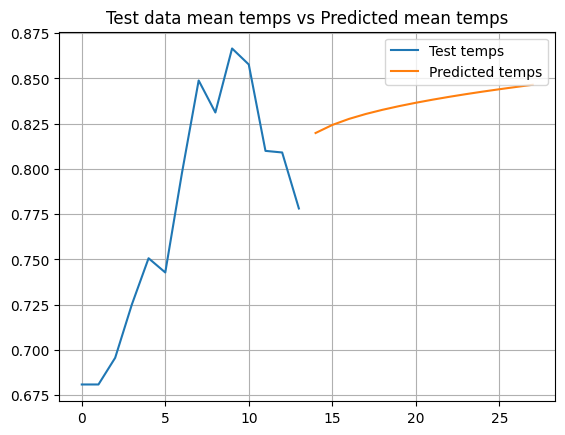

In [31]:
mean_temps_test_length = len(y_test)

# plotting test data vs pred data
plt.title("Test data mean temps vs Predicted mean temps")
plt.plot(range(mean_temps_test_length), y_test, label='Test temps')
plt.plot(range(mean_temps_test_length, mean_temps_test_length + upcoming_days), y_test_preds, label='Predicted temps')
plt.grid(True)
plt.legend()
plt.show()